In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, Trainer, TrainingArguments
import torch.nn as nn
import torch

# New file for BERT tuning
Meant for using the new data (the one that uses all the reddit posts and comments), as well as to make the baseline BERT and fine-tuning model more consistent.

# Baseline BERT

In [16]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

In [3]:
def map_star_to_sentiment(star):
    if '1 star' in star or '2 stars' in star:
        return "negative"
    elif '3 stars' in star:
        return "neutral"
    else:
        return "positive"

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}

In [5]:
def get_confusion(filename, fig_name):
    df = pd.read_csv(filename, encoding='utf-8')

    df['star_level'] = df['text'].apply(lambda x: classifier(x, **tokenizer_kwargs)[0]['label'])

    df['baseline'] = df['star_level'].apply(map_star_to_sentiment)

    print(df.head())

    accuracy = (df['sentiment'] == df['baseline']).mean()

    print(f"Accuracy: {accuracy * 100:.2f}%\n")

    ground_order = ['positive', 'neutral', 'negative']
    pred_order = ['positive', 'neutral', 'negative']


    confusion_matrix = pd.crosstab(df['sentiment'], df['baseline'],
                               rownames=['Ground Truth'], colnames=['Predicted'],)
    confusion_matrix = confusion_matrix.reindex(index=ground_order, columns=pred_order)

    print(confusion_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)

    plt.title(fig_name)
    plt.ylabel('Ground Truth Label')
    plt.xlabel('Predicted Label')

    plt.show()

## Baseline BERT Results

### 2020 Election Cycle Accuracy

    selftext  created_utc  ups  subreddit flair  \
0        NaN   1234718184    6  democrats   NaN   
1        NaN   1240886277    2  democrats   NaN   
2        NaN   1256307176    0  democrats   NaN   
3        NaN   1264531841    2  democrats   NaN   
4  [deleted]   1269378722    0  democrats   NaN   

                                               title  \
0               Will Democrats Ruin President Obama?   
1  Mr. Geithner’s Five Years As President Of The ...   
2  Obama Sees Worst Poll Rating Drop, "Steepest" ...   
3          Joe, Don't Insult Our President Tomorrow!   
4  WATCH: Vice President Biden Drops F-Bomb Durin...   

                                                text    neg    neu    pos  \
0              Will Democrats Ruin President Obama?   0.487  0.513  0.000   
1  Mr. Geithner’s Five Years As President Of The ...  0.000  1.000  0.000   
2  Obama Sees Worst Poll Rating Drop, "Steepest" ...  0.228  0.772  0.000   
3         Joe, Don't Insult Our President Tomorr

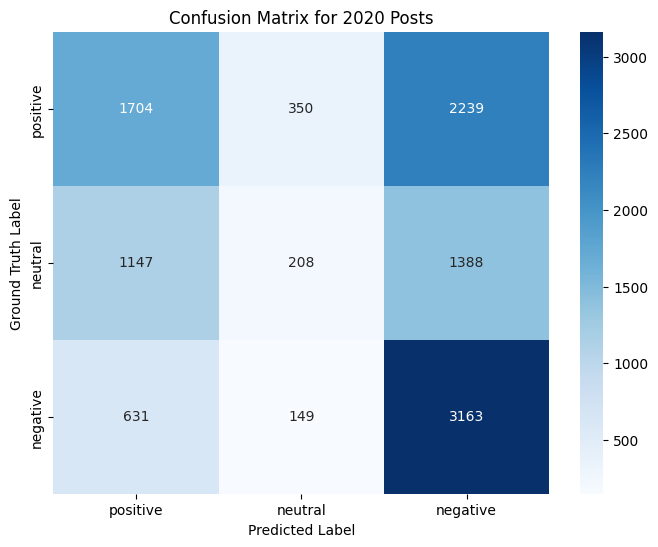

In [6]:
get_confusion('./data/r_labeled_posts_2020.csv', 'Confusion Matrix for 2020 Posts')

                                                text  created_utc  ups  \
0  18 days wut\n\nYou're missing the point, thoug...   1276050379    1   
1  I definitely don't believe that Obama's disapp...   1276053594    3   
2  He's still the president. They should give him...   1287870058    1   
3  As someone who lives in Alabama and has Bedfor...   1291181393    2   
4  I think that pretty much nails it. Anyway, exc...   1291854330    2   

   subreddit    neg    neu    pos  compound sentiment star_level  baseline  
0  democrats  0.086  0.824  0.090    0.4885  positive    2 stars  negative  
1  democrats  0.057  0.807  0.136    0.9931  positive    2 stars  negative  
2  democrats  0.000  1.000  0.000    0.0000   neutral    5 stars  positive  
3  democrats  0.086  0.833  0.082   -0.3397  negative    2 stars  negative  
4  democrats  0.143  0.607  0.251    0.8225  positive    5 stars  positive  
Accuracy: 46.21%

Predicted     positive  neutral  negative
Ground Truth                     

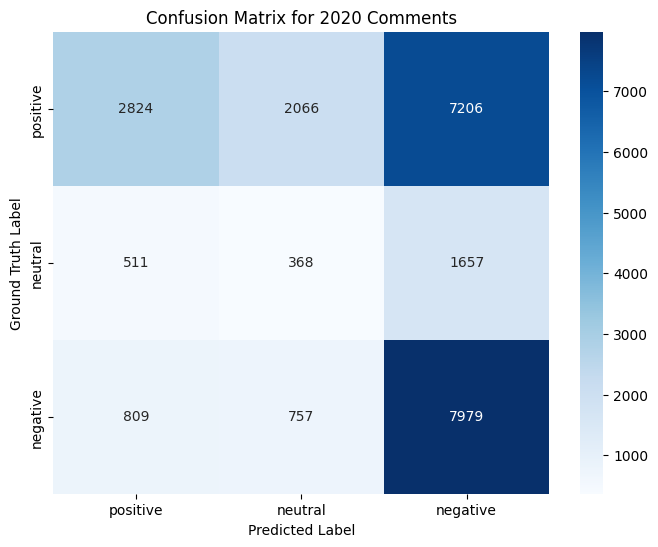

In [7]:
get_confusion('./data/r_labeled_comments_2020.csv', 'Confusion Matrix for 2020 Comments')

### 2024 Election Cycle Accuracy

                                            selftext  created_utc  ups  \
0  Florida Gov. Ron DeSantis says he’ll make sure...   1717215601   54   
1  President Joe Biden reached a milestone last w...   1717291465  295   
2              Is this guy totally deranged or what?   1717291545  125   
3  The Filibuster is a tool that requires 60 vote...   1717370900  198   
4                                                NaN   1717413099    1   

   subreddit                                             flair  \
0  democrats                                   :snoo: Article    
1  democrats                                               NaN   
2  democrats                                               NaN   
3  democrats  :snoo_feelsgoodman: Discussion :snoo_thoughtful:   
4  democrats                                               NaN   

                                               title  \
0   DeSantis says Trump can still vote in Florida...   
1      How Biden has restored fairness to the 

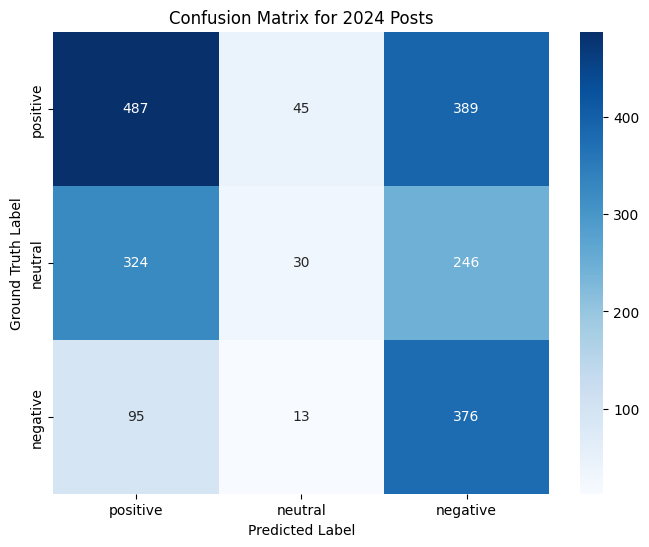

In [8]:
get_confusion('./data/r_labeled_posts_2024.csv', 'Confusion Matrix for 2024 Posts')

                                                text  created_utc  ups  \
0  They sure are making the rounds today. Our sys...   1717200019    1   
1  I would say it’s both. Because after a super c...   1717200509    6   
2  According to the writer, if it were a movement...   1717209701    3   
3  Biden should declare by executive order the di...   1717218519    1   
4  "I wasn't sure when he relentlessly abused me ...   1717221279   23   

   subreddit    neg    neu    pos  compound sentiment star_level  baseline  
0  democrats  0.104  0.782  0.113    0.2005  positive    3 stars   neutral  
1  democrats  0.000  0.865  0.135    0.5994  positive    3 stars   neutral  
2  democrats  0.079  0.870  0.052   -0.2617  negative    3 stars   neutral  
3  democrats  0.100  0.746  0.154    0.7717  positive     1 star  negative  
4  democrats  0.179  0.771  0.051   -0.8394  negative     1 star  negative  
Accuracy: 47.99%

Predicted     positive  neutral  negative
Ground Truth                     

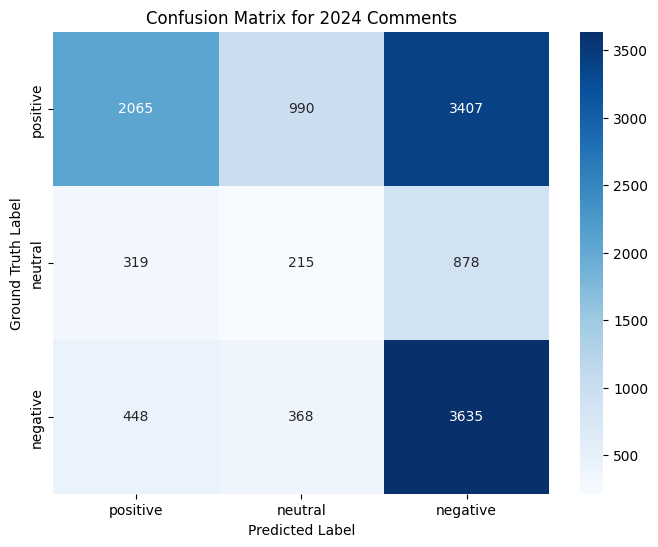

In [9]:
get_confusion('./data/r_labeled_comments_2024.csv', 'Confusion Matrix for 2024 Comments')

# Finetune BERT

### Comments

In [12]:
def relabel(file):
    df = pd.read_csv(file)
    print(df.head(5))

    df = df.rename(columns={'sentiment': 'label'})

    def map_labels(rating):
        if rating == "negative":
            return 0  # Negative
        elif rating == "neutral":
            return 1  # Neutral
        else:
            return 2
        
    df['label'] = df['label'].apply(map_labels)
    return df

In [13]:
df2020 = relabel('./data/labeled_comments_2020.csv')
df2024 = relabel('./data/labeled_comments_2024.csv')

                                                text  created_utc  ups  \
0  Very true, but the problem is that even at tha...   1590975768    1   
1  You’re full of crap.\r\n\r\nYou present no fac...   1590984758    2   
2  Politically speaking, there is absolutely no w...   1590995791   29   
3  This is what happens when the president of the...   1591008451    1   
4  Silly comment. No matter how bad a president h...   1591013669    1   

   subreddit    neg    neu    pos  compound sentiment  
0  democrats  0.239  0.645  0.116   -0.9769  negative  
1  democrats  0.163  0.692  0.145   -0.1101  negative  
2  democrats  0.062  0.823  0.115    0.9925  positive  
3  democrats  0.000  0.903  0.097    0.4215  positive  
4  democrats  0.261  0.647  0.092   -0.8060  negative  
                                                text  created_utc  ups  \
0  They sure are making the rounds today. Our sys...   1717200019    1   
1  I would say it’s both. Because after a super c...   1717200509    6 

In [15]:
# split into train and test data
def split_data(df2020, df2024):
    train_size = int(df2020.shape[0] * 0.8)
    test_size = min(df2020.shape[0] - train_size, df2024.shape[0])    # choose either 20% or the entirety of the df2024 data (whichever is smaller)

    train_df = df2020.sample(n=train_size, random_state=42)      # get random rows
    test_df = df2024.sample(n=test_size, random_state=42)

    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, test_dataset

train_dataset, test_dataset = split_data(df2020, df2024)

In [17]:
model.classifier = nn.Linear(model.config.hidden_size, 3)

In [18]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 40/40 [00:00<00:00, 372.86 examples/s]


In [19]:
print(train_dataset[0])

{'text': "Eh, I think that's shortsighted. If someone kills trump, he becomes martyred and all of these protests will lose their power. The American people by and large are usually swayed towards the side of the victim. Right now, the victims are victims of police brutality. If we make the cops or president a bigger victim, public opinion will sway towards them.\r\n\r\nWe're all just bleeding hearts, at the end of the day. But our hearts bleed for different causes, and different victims. That's why non-violent protests are the number 1 way to go right now, along with writing letters to our representatives. I'm not saying non-violent acts are effective 100% of the time when it comes to producing change, but they do end up being on the morally just side of history more often than the violent acts. They killed Lincoln, and he freed the slaves, and now people side with Lincoln. They killed MLK, and he promoted civil rights, and now people side with MLK. The killers just don't end up as the

In [20]:
print(f"Classifier output size: {model.classifier.out_features}")
print(train_dataset['label'][:100]) 

Classifier output size: 3
[0, 0, 2, 0, 0, 1, 2, 0, 0, 2, 2, 2, 1, 0, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 2, 1]


In [21]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [26]:
batch_size = 16
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    logging_dir='./logs'
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)

eval_log = None
trainer.train()
eval_log = trainer.evaluate()


print(f'Evaluation Log: {eval_log}')

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>={ACCELERATE_MIN_VERSION}'`

In [ ]:
#edit this cell to output evaluation and confusion matrix

def tuned_confusion_matrix(filename, fig_name):
    df = pd.read_csv(filename, encoding='utf-8')

    df['star_level'] = df['text'].apply(lambda x: classifier(x, **tokenizer_kwargs)[0]['label'])

    df['baseline'] = df['star_level'].apply(map_star_to_sentiment)

    print(df.head())

    accuracy = (df['label'] == df['baseline']).mean()

    print(f"Accuracy: {accuracy * 100:.2f}%\n")

    ground_order = ['positive', 'neutral', 'negative']
    pred_order = ['positive', 'neutral', 'negative']


    confusion_matrix = pd.crosstab(df['label'], df['baseline'],
                               rownames=['Ground Truth'], colnames=['Predicted'],)
    confusion_matrix = confusion_matrix.reindex(index=ground_order, columns=pred_order)

    print(confusion_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)

    plt.title(fig_name)
    plt.ylabel('Ground Truth Label')
    plt.xlabel('Predicted Label')

    plt.show()

In [ ]:
# CHANGE THIS CELL so that it actually gets the test dataset labels + text

correct_predictions = 0
total_predictions = len(test_dataset)

wrong_prediction_sentences = []

# Iterate through the test dataset
for i in range(total_predictions):
  label = test_dataset[i]['label']
  inputs = tokenizer([test_dataset[i]['text']], padding=True, truncation=True, return_tensors="pt").to(model.device)

  outputs = model(**inputs)
  probabilities = torch.softmax(outputs.logits, dim=1)
  prediction = torch.argmax(probabilities, dim=1).item()

  if prediction == label:
    correct_predictions += 1
  else:
    wrong_prediction_sentences.append(test_dataset[i]['text'])

print(f"Total correct predictions: {correct_predictions}")
print(f"Total predictions: {total_predictions}")
accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy}")